# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

# Descriptive Statistics

In [ ]:
df = pd.read_csv('titanic.csv')
df

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
df.nunique()

,0
passengerid,891
survived,2
pclass,3
name,891
sex,2
age,88
sibsp,7
parch,7
ticket,681
fare,248


In [ ]:
df.isnull().sum()

,0
passengerid,0
survived,0
pclass,0
name,0
sex,0
age,177
sibsp,0
parch,0
ticket,0
fare,0


## Split target variable

In [ ]:
X = df.drop('survived', axis=1)
y = df['survived']

# X_train = df.drop('survived', axis=1)
# y_train = df['survived']

# EDA

## EDA Functions

In [ ]:
def eda(df):
    # Split ticket prefixes
    dataframe = df.copy()
    dataframe.columns = dataframe.columns.str.lower()

    def extract_ticket_prefix(ticket):
        ticket = str(ticket).strip()
        if ticket[0].isdigit():
            return '0'
        match = re.match(r'^([A-Za-z0-9./]+)', ticket)
        if match:
            prefix = match.group(1)
            return prefix.replace('.', '')
        return '0'

    dataframe['ticket_prefix'] = dataframe['ticket'].apply(extract_ticket_prefix).str.strip().replace('', pd.NA)
    dataframe['ticket_number'] = dataframe['ticket'].str.extract(r'(\d+)$')

    # Round age
    def custom_round(x):
        if pd.isna(x):
            return x
        decimal_part = x - int(x)
        first_decimal_digit = int(decimal_part * 10)
        if first_decimal_digit >= 5:
            return np.ceil(x)
        else:
            return np.floor(x)

    dataframe['age'] = dataframe['age'].apply(custom_round)

    # Split and group passenger title
    dataframe['passenger_title'] = dataframe['name'].str.extract(r',\s*([^\.]+)\.')

    # Group name based on surname
    ## Extract surname from the "Name" column
    dataframe['surname'] = dataframe['name'].str.split(',').str[0].str.strip()

    ## Count family sizes by surname
    surname_counts = dataframe['surname'].value_counts()

    ## Add a FamilySize column (number of passengers with same surname)
    dataframe['family_size'] = dataframe['surname'].map(surname_counts)

    ## Group surnames into bins (single vs small family vs large family)
    def categorize_family_size(size):
        if size == 1:
            return "Single"
        elif size <= 3:
            return "Small"
        else:
            return "Large"

    dataframe['family_group'] = dataframe['family_size'].apply(categorize_family_size)

    # Split deck
    dataframe['deck'] = dataframe['cabin'].apply(lambda x: x[0] if pd.notna(x) else pd.NA)

    # Split
    df_exp = dataframe.copy()

    # Drop redundant features
    df_exp = df_exp.drop('passengerid', axis=1)
    dataframe = dataframe.drop(['passengerid', 'name', 'ticket', 'cabin', 'ticket_number'], axis=1)

    # Change pclass to object type
    dataframe['pclass'] = dataframe['pclass'].astype('object')

    return dataframe, df_exp

X, df_exp = eda(X)
df_viz, df_exp_viz = eda(df)

In [ ]:
def plot(df):

    sns.set(style="whitegrid")

    # Numerical distributions
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    df[numeric_cols].hist(bins=20, figsize=(20, 8), edgecolor='black')
    plt.suptitle("Numeric Feature Distributions", fontsize=16)
    plt.show()

    # Categorical counts
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        plt.figure(figsize=(20, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Count of {col}", fontsize=14)
        plt.xticks(rotation=45)
        plt.show()

    # Survival rates by category
    if 'survived' in numeric_cols:
        for col in categorical_cols:
            if col != 'survived':
                plt.figure(figsize=(20, 4))
                sns.countplot(data=df, x=col, hue='survived', order=df[col].value_counts().index)
                plt.title(f"Survival by {col}", fontsize=14)
                plt.xticks(rotation=45)
                plt.show()
    else:
        pass

In [ ]:
def num_corr(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

    plt.figure(figsize=(10, 6))
    corr = df[numeric_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap (Numeric Features)", fontsize=16)
    plt.show()

In [ ]:
from scipy.stats import chi2_contingency

def cat_corr(df):
    def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    # Select categorical features
    df['survived'] = df['survived'].astype("object")
    categorical_cols = df.select_dtypes(include=["object", "category"]).columns

    # Compute Cramér’s V
    matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                          index=categorical_cols, columns=categorical_cols)

    for col1 in categorical_cols:
        for col2 in categorical_cols:
            matrix.loc[col1, col2] = cramers_v(df[col1], df[col2])

    # Plot heatmap
    plt.figure(figsize=(8,6))
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    sns.heatmap(matrix, mask=mask, annot=True, cmap="coolwarm", vmin=0, vmax=1)
    plt.title("Cramér's V Correlation Matrix for Categorical Features")
    plt.show()

In [ ]:
def fill_na(df, col):
    df = df.copy()
    non_null = df[col].dropna()
    df.loc[df[col].isna(), col] = np.random.choice(non_null, size=df[col].isna().sum(), replace=True)
    return df

## EDA

In [ ]:
# plot(df_viz)

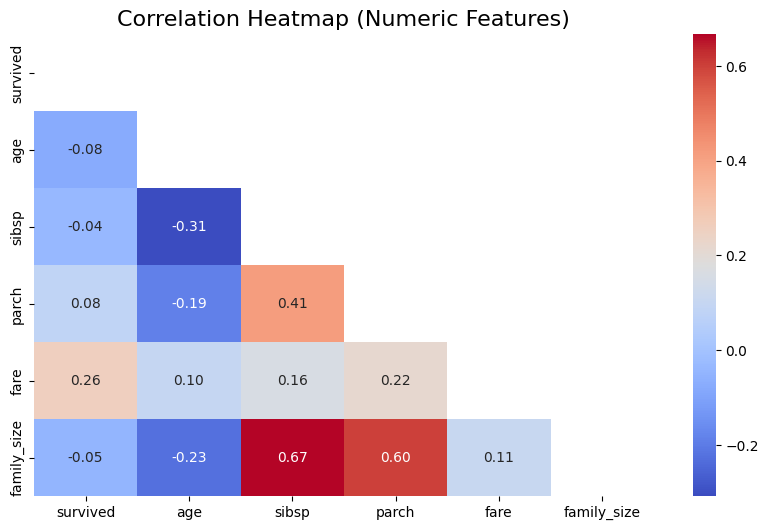

In [ ]:
num_corr(df_viz)

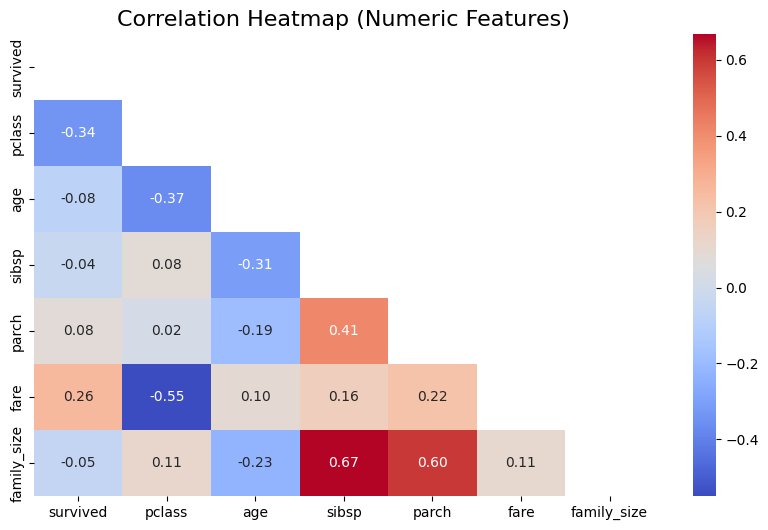

In [ ]:
num_corr(df_exp_viz)

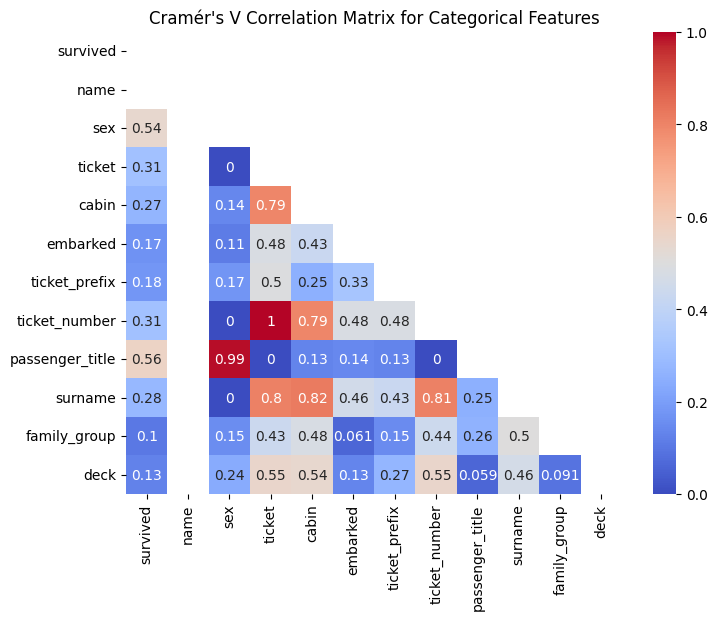

In [ ]:
cat_corr(df_exp_viz)

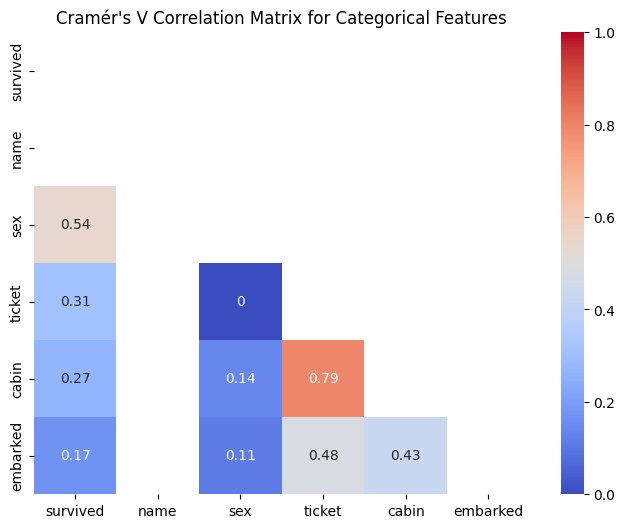

In [ ]:
cat_corr(df)

In [ ]:
df_nonan = fill_na(df_exp, 'cabin')

contingency = pd.crosstab(df_exp['ticket_number'], df_exp['cabin'])

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi2 Statistic:", chi2)
print("p-value:", p)

Chi2 Statistic: 25823.0
p-value: 7.327962547684939e-134


In [ ]:
n = contingency.sum().sum()
phi2 = chi2 / n
r, k = contingency.shape
cramers_v = np.sqrt(phi2 / min(r-1, k-1))

print("Cramer's V:", cramers_v)

Cramer's V: 0.9508767883730608


In [ ]:
# Group decks
def group_decks(df, deck_col='deck'):

    mapdeck = {
        'A': 'Upper',
        'B': 'Upper',
        'C': 'Upper',
        'D': 'Middle',
        'E': 'Middle',
        'F': 'Lower',
        'G': 'Lower',
        'T': 'Special'
    }

    df[deck_col] = df[deck_col].map(mapdeck)
    return df

X = group_decks(X)
df_viz = group_decks(df_viz)

In [ ]:
# Contigency table
contingency_counts = pd.crosstab(X['deck'], X['pclass'])

# Row percentages
contingency_row_pct = pd.crosstab(X['deck'], X['pclass'], normalize='index') * 100

print(f'''Contigency Table:\n{contingency_counts}''')
print(f'''\nPercentage Table:\n{contingency_row_pct.round(2)}''')

Contigency Table:
pclass     1  2  3
deck              
Lower      0  8  9
Middle    54  8  3
Special    1  0  0
Upper    121  0  0

Percentage Table:
pclass        1      2      3
deck                         
Lower      0.00  47.06  52.94
Middle    83.08  12.31   4.62
Special  100.00   0.00   0.00
Upper    100.00   0.00   0.00


In [ ]:
X['passenger_title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [ ]:
# Group passenger titles
def group_titles(df, title_col="passenger_title"):

    title_groups = {
        "Military Officer": ['Capt', 'Col', 'Major', 'Dr', 'Rev'],
        "Royalty": ['Jonkheer', 'Don', 'Sir', 'the Countess', 'Lady'],
        "Miss": ['Miss', 'Mlle', 'Ms'],
        "Mrs": ['Mrs', 'Mme'],
        "Mr": ['Mr'],
        "Master": ['Master']
    }

    maptitle = {}
    for group, titles in title_groups.items():
        for title in titles:
            maptitle[title] = group

    df[title_col] = df[title_col].map(maptitle).fillna(df[title_col])

    return df

X = group_titles(X)
df_viz = group_titles(df_viz)

In [ ]:
# sorted(X['ticket_prefix'].unique())

In [ ]:
# Group decks
def group_prefixes(df, prefix_col='ticket_prefix'):

    prefix_groups = {
    #     "A": ['A/5', 'A/4', 'A/S', 'A4', 'A5'],
    #     "CA": ['CA', 'CA/SOTON'],
    #     "FC": ['FC', 'FCC'],
    #     "SC": ['SC', 'SC/A4', 'SC/AH', 'SC/PARIS', 'SC/Paris', 'SCO/W'],
    #     "SO": ['SO/C', 'SO/PP', 'SOC', 'SOP'],
    #     "SOTON": ['SOTON/O2', 'SOTON/OQ'],
    #     "STON": ['STON/O', 'STON/O2'],
    #     "WE": ['WE/P', 'WEP'],
    #     "No prefix": ['0'],
    #     "Others": ['C', 'Fa', 'LINE', 'P/PP', 'PC', 'PP', 'SP', 'SW/PP', 'W/C']

    # }

        "A": ['A/5', 'A/4', 'A/S', 'A4', 'A5'],
        "CA": ['CA', 'CA/SOTON'],
        "No prefix": ['0'],
        "Others": ['WE/P', 'WEP','STON/O', 'STON/O2','SOTON/O2', 'SOTON/OQ',
                   'SO/C', 'SO/PP', 'SOC', 'SOP','SC', 'SC/A4', 'SC/AH',
                   'SC/PARIS', 'SC/Paris', 'SCO/W','FC', 'FCC', 'C', 'Fa',
                   'LINE', 'P/PP', 'PC', 'PP', 'SP', 'SW/PP', 'W/C']

    }

    mapprefix = {}
    for group, prefixes in prefix_groups.items():
        for prefix in prefixes:
            mapprefix[prefix] = group

    df[prefix_col] = df[prefix_col].map(mapprefix).fillna(df[prefix_col])

    return df

X = group_prefixes(X)
df_viz = group_prefixes(df_viz)

In [ ]:
# plot(df_viz)

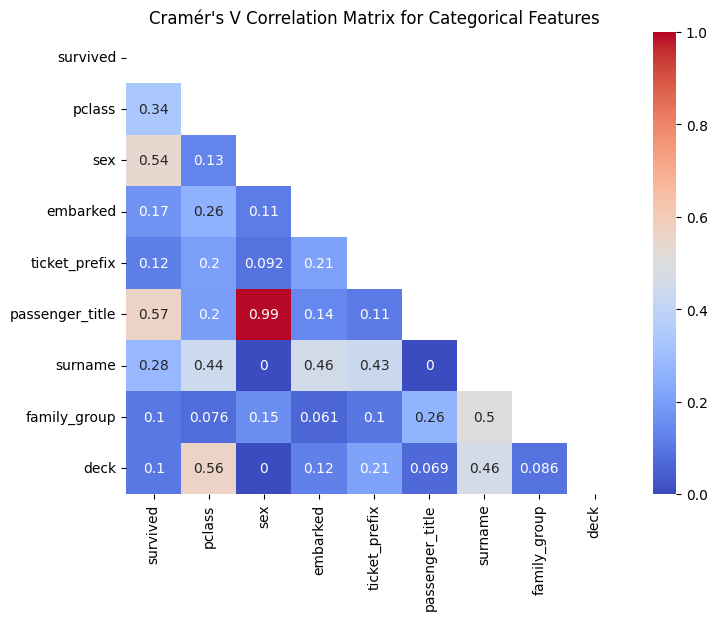

In [ ]:
cat_corr(df_viz)

In [ ]:
X.isnull().sum()

,0
pclass,0
sex,0
age,177
sibsp,0
parch,0
fare,0
embarked,2
ticket_prefix,0
passenger_title,0
surname,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pclass           891 non-null    object 
 1   sex              891 non-null    object 
 2   age              714 non-null    float64
 3   sibsp            891 non-null    int64  
 4   parch            891 non-null    int64  
 5   fare             891 non-null    float64
 6   embarked         889 non-null    object 
 7   ticket_prefix    891 non-null    object 
 8   passenger_title  891 non-null    object 
 9   surname          891 non-null    object 
 10  family_size      891 non-null    int64  
 11  family_group     891 non-null    object 
 12  deck             204 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 90.6+ KB


In [ ]:
empty_cols = X.columns[X.isnull().any()].tolist()

for col in empty_cols:
    X = fill_na(X, col)
    df_viz = fill_na(df_viz, col)

In [ ]:
X.isnull().sum()

,0
pclass,0
sex,0
age,0
sibsp,0
parch,0
fare,0
embarked,0
ticket_prefix,0
passenger_title,0
surname,0


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pclass           891 non-null    object 
 1   sex              891 non-null    object 
 2   age              891 non-null    float64
 3   sibsp            891 non-null    int64  
 4   parch            891 non-null    int64  
 5   fare             891 non-null    float64
 6   embarked         891 non-null    object 
 7   ticket_prefix    891 non-null    object 
 8   passenger_title  891 non-null    object 
 9   surname          891 non-null    object 
 10  family_size      891 non-null    int64  
 11  family_group     891 non-null    object 
 12  deck             891 non-null    object 
dtypes: float64(2), int64(3), object(8)
memory usage: 90.6+ KB


In [ ]:
X = X.drop(['sex', 'age', 'sibsp', 'parch','surname', 'family_size', 'family_group', 'deck'], axis=1 )

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   pclass           891 non-null    object 
 1   fare             891 non-null    float64
 2   embarked         891 non-null    object 
 3   ticket_prefix    891 non-null    object 
 4   passenger_title  891 non-null    object 
dtypes: float64(1), object(4)
memory usage: 34.9+ KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
num_features = X.select_dtypes(include=['float64', 'int64']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_transformer = RobustScaler()
cat_transformer = OneHotEncoder(drop="first", handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features)
    ])

In [ ]:
from xgboost import XGBClassifier

for col in cat_features:
    X_train[col] = X_train[col].astype("category")
    X_test[col] = X_test[col].astype("category")

xgbc = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
                        enable_categorical=True,
                        tree_method="hist",
                        n_estimators=200,
                        learning_rate=0.05,
                        max_depth=5,
                        random_state=42,
                        use_label_encoder=False,
                        eval_metric="logloss"
                    ))
])

# xgbc = XGBClassifier(
#           enable_categorical=True,
#           tree_method="hist",
#           n_estimators=200,
#           learning_rate=0.05,
#           max_depth=4,
#           random_state=42,
#           use_label_encoder=False,
#           eval_metric="logloss"
#         )

xgbc.fit(X_train, y_train)

# Predictions
y_xgbc = xgbc.predict(X_test)

In [ ]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

def evaluation(result):
    # Metrics
    print("Accuracy:", accuracy_score(y_test, result))
    print("Precision:", precision_score(y_test, result))
    print("Recall:", recall_score(y_test, result))
    print("F1 Score:", f1_score(y_test, result))

    # Classification report
    print("\nClassification Report:\n")
    print(classification_report(y_test, result))

    # Confusion matrix
    cm = confusion_matrix(y_test, result)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.title("Confusion Matrix")
    plt.show()

Accuracy: 0.8333333333333334
Precision: 0.7441860465116279
Recall: 0.8888888888888888
F1 Score: 0.810126582278481

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        54
           1       0.74      0.89      0.81        36

    accuracy                           0.83        90
   macro avg       0.83      0.84      0.83        90
weighted avg       0.85      0.83      0.83        90



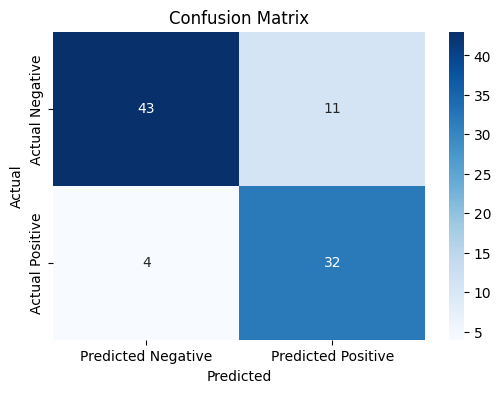

In [ ]:
evaluation(y_xgbc)

In [ ]:
from sklearn.linear_model import LogisticRegression

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
                      random_state=42,
                      solver='liblinear',
                      max_iter=1000
                    ))
])

clf.fit(X_train, y_train)

# Predictions
y_log = clf.predict(X_test)

Accuracy: 0.7222222222222222
Precision: 0.7037037037037037
Recall: 0.5277777777777778
F1 Score: 0.6031746031746031

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.85      0.79        54
           1       0.70      0.53      0.60        36

    accuracy                           0.72        90
   macro avg       0.72      0.69      0.69        90
weighted avg       0.72      0.72      0.71        90



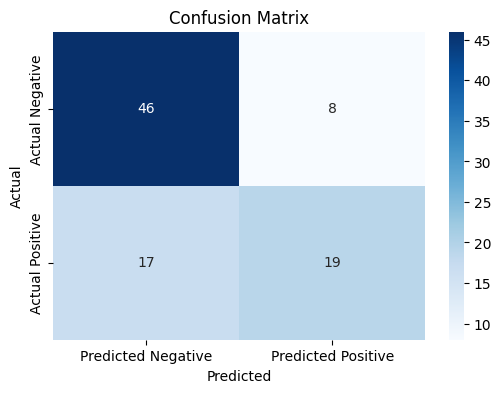

In [ ]:
evaluation(y_log)

In [ ]:
from lightgbm import LGBMClassifier

# lgbm = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", LGBMClassifier(
#                       n_estimators=200,
#                       learning_rate=0.05,
#                       random_state=42
#                     ))
# ])

lgbm = LGBMClassifier(
          n_estimators=200,
          learning_rate=0.05,
          random_state=42
        )

lgbm.fit(X_train, y_train)

# Predictions
y_lgbm = lgbm.predict(X_test)

Accuracy: 0.7888888888888889
Precision: 0.6888888888888889
Recall: 0.8611111111111112
F1 Score: 0.7654320987654321

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.74      0.81        54
           1       0.69      0.86      0.77        36

    accuracy                           0.79        90
   macro avg       0.79      0.80      0.79        90
weighted avg       0.81      0.79      0.79        90



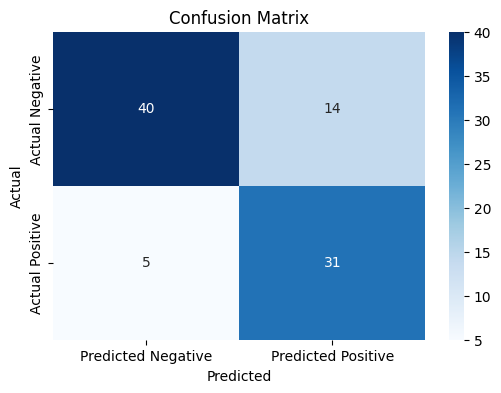

In [ ]:
evaluation(y_lgbm)

In [ ]:
# from catboost import CatBoostClassifier

# catboost = Pipeline(steps=[
#     ("preprocessor", preprocessor),
#     ("classifier", CatBoostClassifier(
                      #   iterations=200,
                      #   learning_rate=0.05,
                      #   random_seed=42,
                      #   verbose=False
                      # ))
# ])

# catboost.fit(X_train, y_train)

## Predictions
# y_pred = catboost.predict(X_test)

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
                      max_depth=3
                    ))
])

# tree = DecisionTreeClassifier(
#           max_depth=3
#         )

tree.fit(X_train, y_train)

# Predictions
y_tree = tree.predict(X_test)

Accuracy: 0.7333333333333333
Precision: 0.7142857142857143
Recall: 0.5555555555555556
F1 Score: 0.625

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.85      0.79        54
           1       0.71      0.56      0.62        36

    accuracy                           0.73        90
   macro avg       0.73      0.70      0.71        90
weighted avg       0.73      0.73      0.73        90



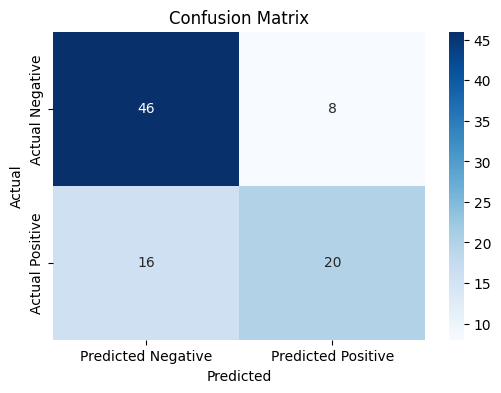

In [ ]:
evaluation(y_tree)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", KNeighborsClassifier(
                      n_neighbors=5
                    ))
])

knn.fit(X_train, y_train)

# Predictions
y_knn = knn.predict(X_test)

Accuracy: 0.7444444444444445
Precision: 0.6756756756756757
Recall: 0.6944444444444444
F1 Score: 0.684931506849315

Classification Report:

              precision    recall  f1-score   support

           0       0.79      0.78      0.79        54
           1       0.68      0.69      0.68        36

    accuracy                           0.74        90
   macro avg       0.73      0.74      0.73        90
weighted avg       0.75      0.74      0.75        90



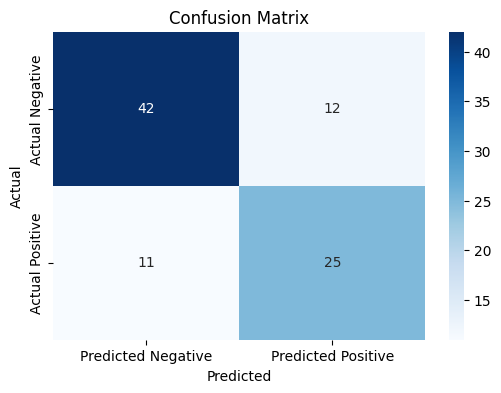

In [ ]:
evaluation(y_knn)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
                      n_estimators=200,
                      max_depth=6,
                      random_state=42
                    ))
])

# rf = RandomForestClassifier(
#         n_estimators=200,
#         max_depth=6,
#         random_state=42
#       )

rf.fit(X_train, y_train)

# Predictions
y_rf = rf.predict(X_test)

Accuracy: 0.8
Precision: 0.7368421052631579
Recall: 0.7777777777777778
F1 Score: 0.7567567567567568

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.81      0.83        54
           1       0.74      0.78      0.76        36

    accuracy                           0.80        90
   macro avg       0.79      0.80      0.79        90
weighted avg       0.80      0.80      0.80        90



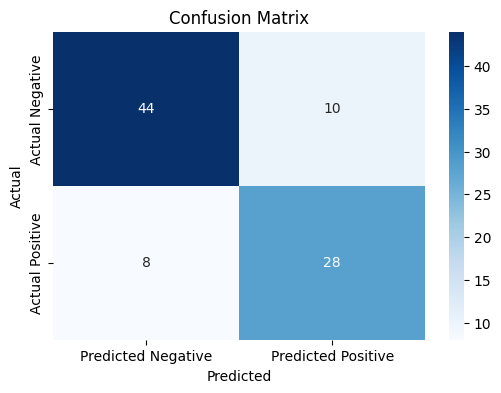

In [ ]:
evaluation(y_rf)

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

predictions = {
    "Random Forest": y_rf,
    "XGBoost": y_xgbc
}

report_dfs = []
for model_name, y_pred in predictions.items():
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    df = pd.DataFrame(report_dict).transpose()
    df["model"] = model_name
    report_dfs.append(df)

comparison_df = pd.concat(report_dfs)
comparison_df.reset_index(inplace=True)
comparison_df.rename(columns={"index": "class"}, inplace=True)

comparison_df = comparison_df[["model", "class", "precision", "recall", "f1-score", "support"]]

print(comparison_df)

weighted_avg_df = comparison_df[comparison_df["class"] == "weighted avg"]
print("\nWeighted Average Comparison:\n", weighted_avg_df)


           model         class  precision    recall  f1-score    support
0  Random Forest             0   0.846154  0.814815  0.830189  54.000000
1  Random Forest             1   0.736842  0.777778  0.756757  36.000000
2  Random Forest      accuracy   0.800000  0.800000  0.800000   0.800000
3  Random Forest     macro avg   0.791498  0.796296  0.793473  90.000000
4  Random Forest  weighted avg   0.802429  0.800000  0.800816  90.000000
5        XGBoost             0   0.914894  0.796296  0.851485  54.000000
6        XGBoost             1   0.744186  0.888889  0.810127  36.000000
7        XGBoost      accuracy   0.833333  0.833333  0.833333   0.833333
8        XGBoost     macro avg   0.829540  0.842593  0.830806  90.000000
9        XGBoost  weighted avg   0.846611  0.833333  0.834942  90.000000

Weighted Average Comparison:
            model         class  precision    recall  f1-score  support
4  Random Forest  weighted avg   0.802429  0.800000  0.800816     90.0
9        XGBoost  weight